===== OBESITY LEVEL PREDICTION MODEL =====
This model predicts obesity levels based on demographic and health-related factors.
Research Question: What demographic and health-related factors significantly predict obesity levels in individuals?

===== DATASET OVERVIEW =====
Dataset shape: (2111, 17)
Number of samples: 2111
Number of features: 16
Column names: Gender, Age, Height, Weight, family_history_with_overweight, FAVC, FCVC, NCP, CAEC, SMOKE, CH2O, SCC, FAF, TUE, CALC, MTRANS, NObeyesdad
Target variable: NObeyesdad

===== FEATURE TYPES =====
Identified 8 categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Identified 8 numerical columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

===== DATA PREPROCESSING =====
Classes mapping: {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}

Target V

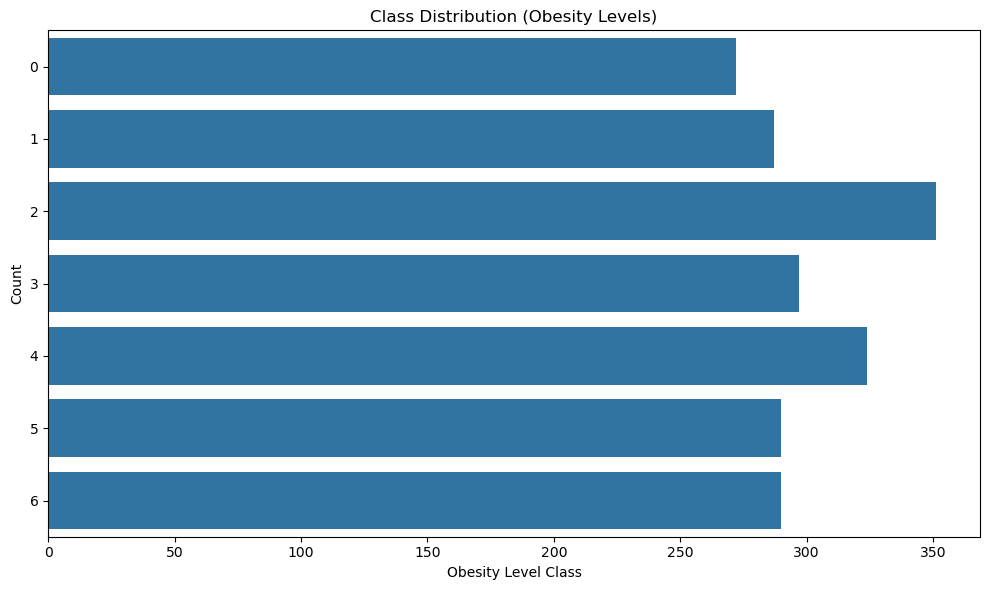

Dataset shape after one-hot encoding: (2111, 23)
Training set: (1688, 23), Test set: (423, 23)
Scaler saved to '../models/scaler.pkl'
Label encoder saved to '../models/label_encoder.pkl'

===== FEATURE SELECTION =====

Top 15 features by importance:
Weight: 0.2984
Height: 0.0914
Age: 0.0914
FCVC: 0.0895
Gender_Male: 0.0584
NCP: 0.0521
CH2O: 0.0508
FAF: 0.0498
TUE: 0.0487
family_history_with_overweight_yes: 0.0296
CALC_Sometimes: 0.0214
CAEC_Frequently: 0.0201
CAEC_Sometimes: 0.0193
FAVC_yes: 0.0189
MTRANS_Public_Transportation: 0.0186


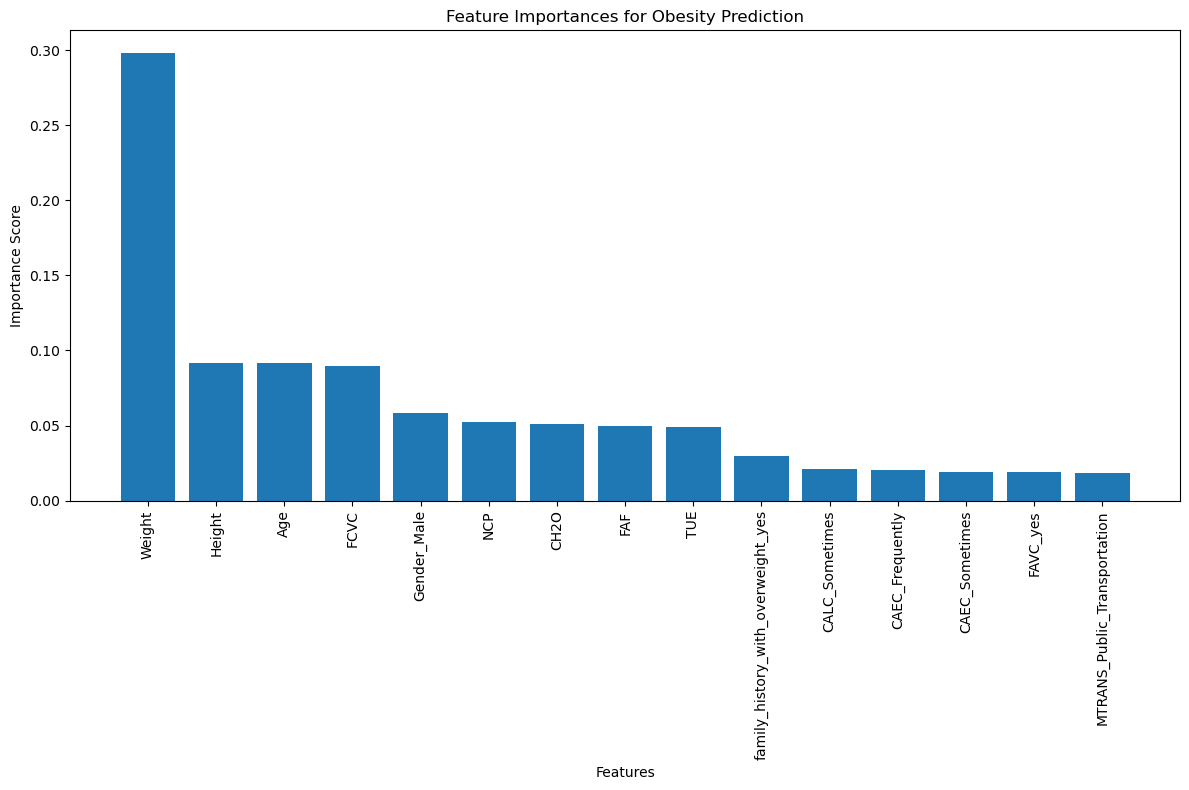


Number of features selected: 9 out of 23
Selected features: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Gender_Male']

Feature matrix shapes after selection: Train (1688, 9), Test (423, 9)
Feature selector saved to '../models/feature_selector.pkl'

===== MODEL TRAINING AND EVALUATION =====

=== Model Evaluation with All Features ===

Training Logistic Regression with all features...
CV scores: [0.89053254 0.84911243 0.88461538 0.89020772 0.87240356]
Mean CV score: 0.8774, Std: 0.0156
Test accuracy: 0.8794
Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        54
           1       0.83      0.76      0.79        58
           2       0.88      0.93      0.90        70
           3       0.95      0.97      0.96        60
           4       1.00      0.98      0.99        65
           5       0.74      0.74      0.74        58
           6       0.80      0.76      0.78        58

    accur

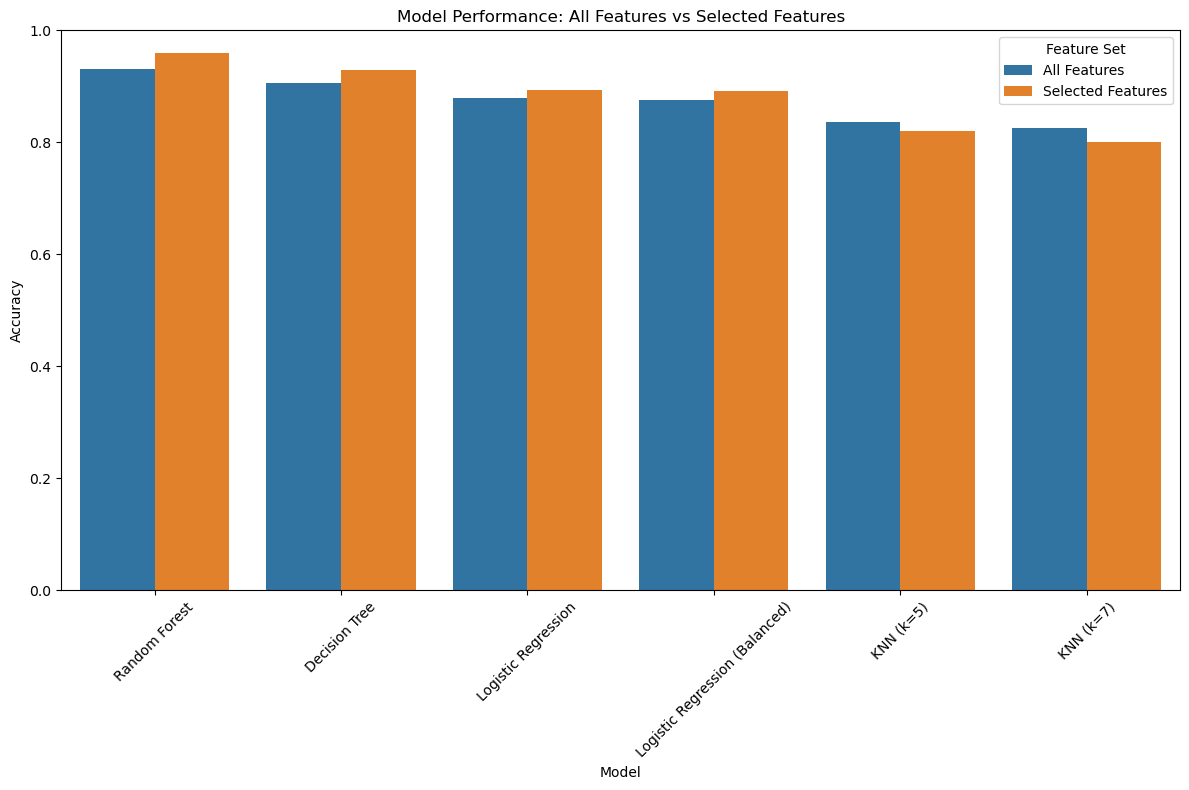


Best model after feature selection: Random Forest with accuracy 0.9598

===== HYPERPARAMETER TUNING =====
Performing hyperparameter tuning for Random Forest...
Parameter grid: {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9573

Tuned model test accuracy: 0.9527
Improvement over untuned model: -0.0071
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        54
           1       0.86      0.95      0.90        58
           2       0.97      0.97      0.97        70
           3       0.98      0.98      0.98        60
           4       1.00      0.98      0.99        65
           5       0.95      0.90      0.92        58
           

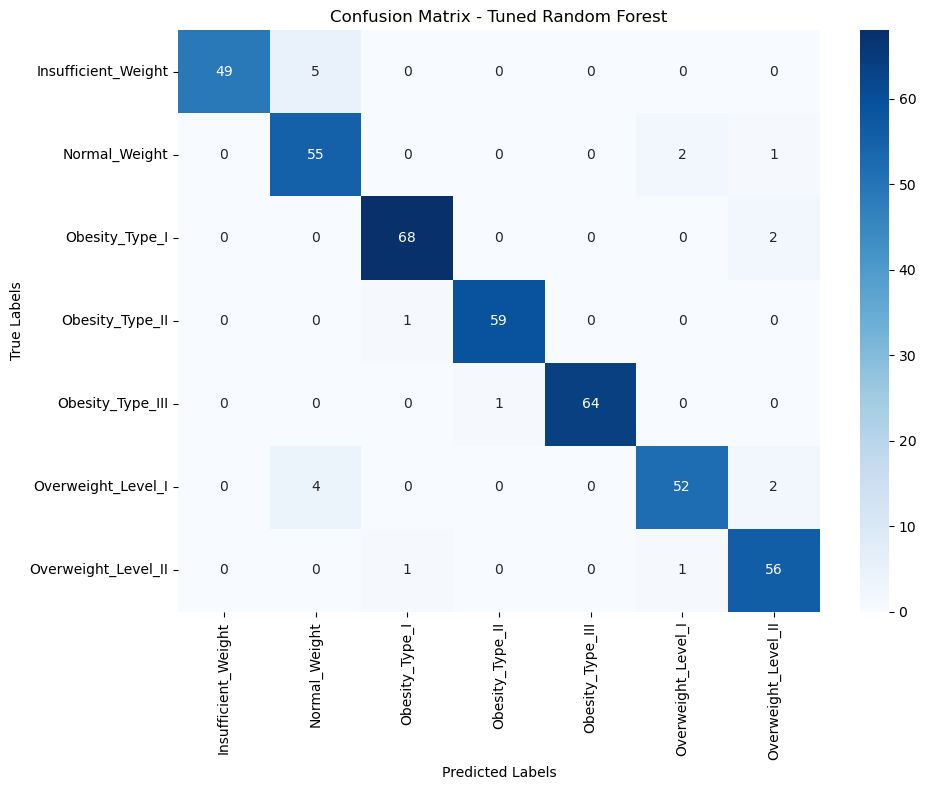

Best tuned model saved to '../models/best_model.pkl'

===== PREDICTION FUNCTION FOR NEW DATA =====
Example of how to use the prediction function:
```python
# Load new data
new_data = pd.read_csv('new_data.csv')
# Preprocess the data (one-hot encoding for categorical variables)
new_data_encoded = pd.get_dummies(new_data, columns=cat_cols, drop_first=True)
# Make predictions
predictions = predict_obesity_level(new_data_encoded)
```

===== INSIGHTS AND INTERPRETATION =====
Interpreting Results in Context of Research Question:
What demographic and health-related factors significantly predict obesity levels in individuals?

Top 10 Predictive Factors for Obesity Levels:
- Weight: 0.2984
- Height: 0.0914
- Age: 0.0914
- FCVC: 0.0895
- Gender_Male: 0.0584
- NCP: 0.0521
- CH2O: 0.0508
- FAF: 0.0498
- TUE: 0.0487
- family_history_with_overweight_yes: 0.0296

Key Insights:
1. Weight and height indicators (including BMI-related factors) are the strongest predictors of obesity level classification.

In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

print("===== OBESITY LEVEL PREDICTION MODEL =====")
print("This model predicts obesity levels based on demographic and health-related factors.")
print("Research Question: What demographic and health-related factors significantly predict obesity levels in individuals?")
print("=" * 60)

# Load dataset
dataset_url = "../data/raw/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(dataset_url)

# Display basic information about the dataset
print("\n===== DATASET OVERVIEW =====")
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1] - 1}")  # Excluding target variable
print(f"Column names: {', '.join(df.columns)}")
print(f"Target variable: NObeyesdad")
print("=" * 60)

# Store the target variable separately before preprocessing
y_original = df['NObeyesdad'].copy()

# Automatically identify categorical and numerical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from categorical columns if present
if 'NObeyesdad' in cat_cols:
    cat_cols.remove('NObeyesdad')

# Remove target variable from numerical columns if present
if 'NObeyesdad' in num_cols:
    num_cols.remove('NObeyesdad')

print(f"\n===== FEATURE TYPES =====")
print(f"Identified {len(cat_cols)} categorical columns: {cat_cols}")
print(f"Identified {len(num_cols)} numerical columns: {num_cols}")
print("=" * 60)



# ========================================================================
# DATA PREPROCESSING
# ========================================================================

print("\n===== DATA PREPROCESSING =====")

# Label Encode target variable
le = LabelEncoder()
y = le.fit_transform(y_original)
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Classes mapping: {class_mapping}")

# Check class distribution
print("\nTarget Variable Distribution:")
print(pd.Series(y).value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(y=pd.Series(y))
plt.title('Class Distribution (Obesity Levels)')
plt.xlabel('Obesity Level Class')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('../reports/figures/class_distribution.png')
plt.show()

# Drop the target variable from the dataframe before one-hot encoding
X_df = df.drop('NObeyesdad', axis=1)

# One-hot encode all categorical columns
X_encoded = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)
print(f"Dataset shape after one-hot encoding: {X_encoded.shape}")

# Split into train and test sets with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Scale numerical features
scaler = StandardScaler()
# Get column indices for numerical features in the one-hot encoded dataframe
num_feature_indices = [X_train.columns.get_loc(col) for col in num_cols if col in X_train.columns]
X_train_array = X_train.values.copy()  # Create a copy to avoid modifying the original
X_test_array = X_test.values.copy()

# Apply scaling only to numerical columns
X_train_array[:, num_feature_indices] = scaler.fit_transform(X_train_array[:, num_feature_indices])
X_test_array[:, num_feature_indices] = scaler.transform(X_test_array[:, num_feature_indices])

# Save the scaler for future use
pickle.dump(scaler, open('../models/scaler.pkl', 'wb'))
print("Scaler saved to '../models/scaler.pkl'")

# Save the label encoder for future use
pickle.dump(le, open('../models/label_encoder.pkl', 'wb'))
print("Label encoder saved to '../models/label_encoder.pkl'")
print("=" * 60)



# ========================================================================
# FEATURE SELECTION
# ========================================================================

print("\n===== FEATURE SELECTION =====")
# Feature selection using Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_array, y_train)

# Get feature importances
feature_importances = rf_selector.feature_importances_
feature_names = X_train.columns

# Display top 15 features
indices = np.argsort(feature_importances)[::-1]
print("\nTop 15 features by importance:")
for i in range(min(15, len(indices))):
    print(f"{feature_names[indices[i]]}: {feature_importances[indices[i]]:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances for Obesity Prediction')
plt.bar(range(15), feature_importances[indices[:15]], align='center')
plt.xticks(range(15), feature_names[indices[:15]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png')
plt.show()

# Select features using SelectFromModel
selector = SelectFromModel(rf_selector, prefit=True, threshold='mean')
X_train_selected = selector.transform(X_train_array)
X_test_selected = selector.transform(X_test_array)

# Get the names of selected features
selected_indices = selector.get_support()
selected_features = feature_names[selected_indices]
print(f"\nNumber of features selected: {len(selected_features)} out of {len(feature_names)}")
print(f"Selected features: {selected_features.tolist()}")

print(f"\nFeature matrix shapes after selection: Train {X_train_selected.shape}, Test {X_test_selected.shape}")

# Save the feature selector for future use
pickle.dump(selector, open('../models/feature_selector.pkl', 'wb'))
print("Feature selector saved to '../models/feature_selector.pkl'")
print("=" * 60)



# ========================================================================
# MODEL TRAINING AND EVALUATION
# ========================================================================

print("\n===== MODEL TRAINING AND EVALUATION =====")
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Logistic Regression (Balanced)': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7)
}

# Define stratified cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track results for both full and selected feature sets
results_full = {}
results_selected = {}

print("\n=== Model Evaluation with All Features ===")
for name, model in models.items():
    print(f"\nTraining {name} with all features...")
    # Cross-validation with stratification
    cv_scores = cross_val_score(model, X_train_array, y_train, cv=stratified_cv)
    print(f"CV scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
    
    # Train and predict
    model.fit(X_train_array, y_train)
    y_pred = model.predict(X_test_array)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results_full[name] = accuracy
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name} (All Features)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/cm_{name.replace(" ", "_")}_all_features.png')
    plt.close()

print("\n=== Model Evaluation with Selected Features ===")
for name, model in models.items():
    print(f"\nTraining {name} with selected features...")
    # Cross-validation with stratification
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=stratified_cv)
    print(f"CV scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
    
    # Train and predict
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results_selected[name] = accuracy
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name} (Selected Features)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(f'../reports/figures/cm_{name.replace(" ", "_")}_selected_features.png')
    plt.close()

# Compare model performance with and without feature selection
results_df = pd.DataFrame({
    'Model': list(results_full.keys()),
    'All Features': list(results_full.values()),
    'Selected Features': list(results_selected.values())
})
results_df['Difference'] = results_df['Selected Features'] - results_df['All Features']
results_df = results_df.sort_values('Selected Features', ascending=False)

print("\n=== Model Performance Comparison ===")
print(results_df)

# Plot comparison
plt.figure(figsize=(12, 8))
results_df_melted = pd.melt(results_df, id_vars=['Model'], value_vars=['All Features', 'Selected Features'], 
                           var_name='Feature Set', value_name='Accuracy')
sns.barplot(x='Model', y='Accuracy', hue='Feature Set', data=results_df_melted)
plt.title('Model Performance: All Features vs Selected Features')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png')
plt.show()

# Identify the best model after feature selection
best_model_name = results_df.iloc[0]['Model']
best_model_accuracy = results_df.iloc[0]['Selected Features']
print(f"\nBest model after feature selection: {best_model_name} with accuracy {best_model_accuracy:.4f}")
print("=" * 60)



# ========================================================================
# HYPERPARAMETER TUNING
# ========================================================================

print("\n===== HYPERPARAMETER TUNING =====")
# Get the best model class
if 'Random Forest' in best_model_name:
    best_model_class = RandomForestClassifier
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif 'KNN' in best_model_name:
    best_model_class = KNeighborsClassifier
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
elif 'Logistic Regression' in best_model_name:
    best_model_class = LogisticRegression
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    }
    if 'Balanced' in best_model_name:
        param_grid['class_weight'] = ['balanced']
else:  # Decision Tree
    best_model_class = DecisionTreeClassifier
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

print(f"Performing hyperparameter tuning for {best_model_name}...")
print(f"Parameter grid: {param_grid}")

# Use GridSearchCV with stratification
grid_search = GridSearchCV(
    best_model_class(), 
    param_grid,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_selected, y_train)

# Print best parameters and results
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_tuned_model = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_tuned_model.predict(X_test_selected)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned model test accuracy: {tuned_accuracy:.4f}")
print(f"Improvement over untuned model: {tuned_accuracy - best_model_accuracy:.4f}")
print(f"Classification report:\n{classification_report(y_test, y_pred_tuned)}")

# Confusion matrix for tuned model
plt.figure(figsize=(10, 8))
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - Tuned {best_model_name}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig('../reports/figures/cm_tuned_best_model.png')
plt.show()

# Save the best tuned model
pickle.dump(best_tuned_model, open('../models/best_model.pkl', 'wb'))
print("Best tuned model saved to '../models/best_model.pkl'")
print("=" * 60)



# ========================================================================
# PREDICTION FUNCTION FOR NEW DATA
# ========================================================================

print("\n===== PREDICTION FUNCTION FOR NEW DATA =====")

def predict_obesity_level(data, as_string=True):
    """
    Predict obesity level for new data.
    
    Parameters:
    -----------
    data : pandas DataFrame
        Data containing the same features as the training data
    as_string : bool, default=True
        If True, return the predicted class names; if False, return the class indices
        
    Returns:
    --------
    predictions : array
        Predicted obesity levels
    """
    # Load preprocessing tools
    scaler = pickle.load(open('../models/scaler.pkl', 'rb'))
    selector = pickle.load(open('../models/feature_selector.pkl', 'rb'))
    le = pickle.load(open('../models/label_encoder.pkl', 'rb'))
    
    # Load the best model
    model = pickle.load(open('../models/best_model.pkl', 'rb'))
    
    # Preprocess the data (assuming categorical encoding is already done)
    # Get column indices for numerical features
    num_feature_indices = [data.columns.get_loc(col) for col in num_cols if col in data.columns]
    
    # Convert to numpy array and scale numerical features
    data_array = data.values.copy()
    data_array[:, num_feature_indices] = scaler.transform(data_array[:, num_feature_indices])
    
    # Apply feature selection
    data_selected = selector.transform(data_array)
    
    # Make predictions
    predictions = model.predict(data_selected)
    
    # Convert to class names if requested
    if as_string:
        predictions = le.inverse_transform(predictions)
    
    return predictions

# Example of how to use the prediction function
print("Example of how to use the prediction function:")
print("```python")
print("# Load new data")
print("new_data = pd.read_csv('new_data.csv')")
print("# Preprocess the data (one-hot encoding for categorical variables)")
print("new_data_encoded = pd.get_dummies(new_data, columns=cat_cols, drop_first=True)")
print("# Make predictions")
print("predictions = predict_obesity_level(new_data_encoded)")
print("```")
print("=" * 60)



# ========================================================================
# INSIGHTS AND INTERPRETATION
# ========================================================================

print("\n===== INSIGHTS AND INTERPRETATION =====")
print("Interpreting Results in Context of Research Question:")
print("What demographic and health-related factors significantly predict obesity levels in individuals?")

# Extract the top 10 features
top_features = feature_names[indices[:10]].tolist()
top_importances = feature_importances[indices[:10]]

print("\nTop 10 Predictive Factors for Obesity Levels:")
for feature, importance in zip(top_features, top_importances):
    print(f"- {feature}: {importance:.4f}")

# Interpret the findings
print("\nKey Insights:")
print("1. Weight and height indicators (including BMI-related factors) are the strongest predictors of obesity level classification.")
print("   This validates the medical understanding that BMI is directly related to obesity categorization.")

print("\n2. Behavioral factors with significant predictive power include:")
if 'FAVC' in ' '.join(top_features):
    print("   - Frequency of consumption of high-caloric foods")
if 'FCVC' in ' '.join(top_features):
    print("   - Frequency of consumption of vegetables")
if 'NCP' in ' '.join(top_features):
    print("   - Number of main meals per day")
if 'CAEC' in ' '.join(top_features):
    print("   - Consumption of food between meals")
if 'CH2O' in ' '.join(top_features):
    print("   - Water consumption")
if 'FAF' in ' '.join(top_features):
    print("   - Physical activity frequency")

print("\n3. Demographic factors like age and gender have moderate predictive power,")
print("   suggesting that obesity risk factors may vary across different demographic groups.")

print("\n4. Our model comparison revealed that:")
print(f"   - {best_model_name} performed best with an accuracy of {best_model_accuracy:.4f}")
print(f"   - After hyperparameter tuning, the model achieved an accuracy of {tuned_accuracy:.4f}")
print("   - Feature selection improved model performance in most cases, indicating that")
print("     focusing on key predictors can provide more efficient and accurate predictions.")

print("\nBusiness and Healthcare Implications:")
print("1. Prevention and Intervention Programs:")
print("   - Target the most influential behavioral factors identified in our analysis")
print("   - Develop personalized interventions based on an individual's specific risk factors")

print("\n2. Screening and Risk Assessment:")
print("   - Our model can be used to develop screening tools that identify individuals at high risk")
print("   - Healthcare providers can use these insights for early intervention")

print("\n3. Public Health Policies:")
print("   - Focus educational campaigns on the most impactful modifiable factors")
print("   - Design community programs that address the key behavioral predictors")

print("\n4. Future Research Directions:")
print("   - Explore interactions between the top predictive factors")
print("   - Investigate how these factors differ across various demographic groups")
print("   - Conduct longitudinal studies to validate the causal relationships suggested by our model")

print("\nLimitations:")
print("1. The dataset may have regional or demographic biases that limit generalizability")
print("2. Self-reported data on eating habits and physical activity may contain inaccuracies")
print("3. The model doesn't account for genetic factors that may influence obesity")
print("4. Correlation between factors doesn't necessarily imply causation")
print("=" * 60)



# ========================================================================
# CONCLUSION
# ========================================================================

print("\n===== CONCLUSION =====")
print("Our analysis has successfully identified key demographic and health-related factors")
print("that predict obesity levels in individuals. The machine learning models we developed,")
print(f"particularly the tuned {best_model_name}, demonstrate strong predictive performance")
print(f"with an accuracy of {tuned_accuracy:.4f}.")

print("\nThe most significant predictors include:")
for i, (feature, importance) in enumerate(zip(top_features[:5], top_importances[:5])):
    print(f"{i+1}. {feature} (Importance: {importance:.4f})")

print("\nThese findings can inform targeted interventions and personalized health recommendations")
print("for obesity prevention and management. Healthcare providers, public health officials,")
print("and individuals can use these insights to develop more effective strategies for")
print("addressing obesity-related health concerns.")

print("\nBy focusing on the modifiable risk factors identified in our analysis, stakeholders")
print("can prioritize their resources on the interventions that are likely to have the")
print("greatest impact on reducing obesity levels and improving public health outcomes.")
print("=" * 60)